In [79]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

In [61]:
# Load feature names
features = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\features.txt', sep="\s+", header=None, names=['index', 'feature_name'])

# Create unique feature names by adding a suffix to duplicates
feature_names = pd.Series(features['feature_name']).reset_index()
feature_names['unique_name'] = feature_names.groupby('feature_name').cumcount().astype(str)
feature_names['unique_name'] = feature_names.apply(
    lambda x: f"{x['feature_name']}_{x['unique_name']}" if x['unique_name'] != '0' else x['feature_name'], 
    axis=1
)
unique_feature_names = feature_names['unique_name'].values

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\prato\AppData\Local\Temp\ipykernel_12652\3838949827.py:2: SyntaxWarning: invalid escape sequence '\s'
  features = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\features.txt', sep="\s+", header=None, names=['index', 'feature_name'])


In [58]:
# Load activity labels
activity_labels = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\activity_labels.txt', sep="\s+", header=None, names=['id', 'activity'])
activity_labels_dict = activity_labels.set_index('id')['activity'].to_dict()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\prato\AppData\Local\Temp\ipykernel_12652\3035275197.py:2: SyntaxWarning: invalid escape sequence '\s'
  activity_labels = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\activity_labels.txt', sep="\s+", header=None, names=['id', 'activity'])


In [59]:
# Load train labels
y_train = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\y_train.txt', header=None, names=['Activity'])
y_train['Activity'] = y_train['Activity'].map(activity_labels_dict)

In [60]:
# Load test labels
y_test = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\y_test.txt', header=None, names=['Activity'])
y_test['Activity'] = y_test['Activity'].map(activity_labels_dict)


In [62]:
# Assuming the feature data is in 'X_train.txt' and 'X_test.txt'
# Load feature data for training and testing sets
X_train = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\X_train.txt', delim_whitespace=True, header=None, names=unique_feature_names)
X_test = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\X_test.txt', delim_whitespace=True, header=None, names=unique_feature_names)

C:\Users\prato\AppData\Local\Temp\ipykernel_12652\4195732514.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\X_train.txt', delim_whitespace=True, header=None, names=unique_feature_names)
C:\Users\prato\AppData\Local\Temp\ipykernel_12652\4195732514.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(r'C:\Users\prato\OneDrive\Desktop\EECE 5644 - Intro to ML\Assignment 1\X_test.txt', delim_whitespace=True, header=None, names=unique_feature_names)


In [63]:
# Combine feature data with labels
train_data = X_train.copy()
train_data['Activity'] = y_train['Activity']

test_data = X_test.copy()
test_data['Activity'] = y_test['Activity']

In [86]:
# Preview the data
print("Training Data:")
print(train_data.head())


#print("\nTest Data:")
#print(test_data.head())

Training Data:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ..

In [65]:
# Step 1: Prepare features and labels
X_train_features = train_data.drop(columns=['Activity']).values
y_train_labels = train_data['Activity'].values

X_test_features = test_data.drop(columns=['Activity']).values
y_test_labels = test_data['Activity'].values

In [87]:
# Regularization parameter to make covariance matrices positive definite
regularization_factor = 1e-2

# Step 2: Estimate Class Priors, Means, and Covariance Matrices
classes = np.unique(y_train_labels)
class_priors = {}
mean_vectors = {}
cov_matrices = {}

In [94]:
for label in classes:
    # Get training samples of each class
    X_class = X_train_features[y_train_labels == label]
    
    # Compute the prior (P(L = label))
    class_priors[label] = len(X_class) / len(X_train_features)
    
    # Compute the mean vector for the class
    mean_vectors[label] = np.mean(X_class, axis=0)
    
    cov_matrix = np.cov(X_class, rowvar=False)
    
    # Add a small value to the diagonal to regularize the covariance matrix
    cov_matrix += regularization_factor * np.eye(cov_matrix.shape[0])
    
    # Store the regularized covariance matrix back into the dictionary
    cov_matrices[label] = cov_matrix


In [75]:
def vectorized_classification(X, class_priors, mean_vectors, cov_matrices):
    scores = []
    for label in classes:
        mean = mean_vectors[label]
        cov = cov_matrices[label]
        
        # Calculate the log of the probability density function to avoid underflow issues
        log_likelihood = multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True)
        
        # Calculate log posterior: log P(L=label|x) = log p(x|L=label) + log P(L=label)
        log_posterior = log_likelihood + np.log(class_priors[label])
        scores.append(log_posterior)
    
    # Convert the scores to a numpy array for easier handling
    scores = np.array(scores)
    
    # Get the index of the maximum log posterior for each sample (each column)
    predicted_labels_indices = np.argmax(scores, axis=0)
    
    # Map indices back to class labels
    predicted_labels = [classes[index] for index in predicted_labels_indices]
    
    return predicted_labels

In [95]:
predictions = vectorized_classification(X_test_features, class_priors, mean_vectors, cov_matrices)

In [96]:
# Step 5: Evaluate with a Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, predictions, labels=classes)
accuracy = accuracy_score(y_test_labels, predictions)

In [97]:
# Step 6: Calculate the Error Rate
error_rate = 1 - accuracy
print(f"Error Rate: {error_rate:.4f}")

Error Rate: 0.0580


In [98]:
print("Confusion Matrix:")
print(conf_matrix)
print(f"\nAccuracy: {accuracy:.4f}")

Confusion Matrix:
[[537   0   0   0   0   0]
 [  1 387 103   0   0   0]
 [  0   7 525   0   0   0]
 [  0   0   0 482  13   1]
 [  0   0   0   4 375  41]
 [  0   0   0   0   1 470]]

Accuracy: 0.9420


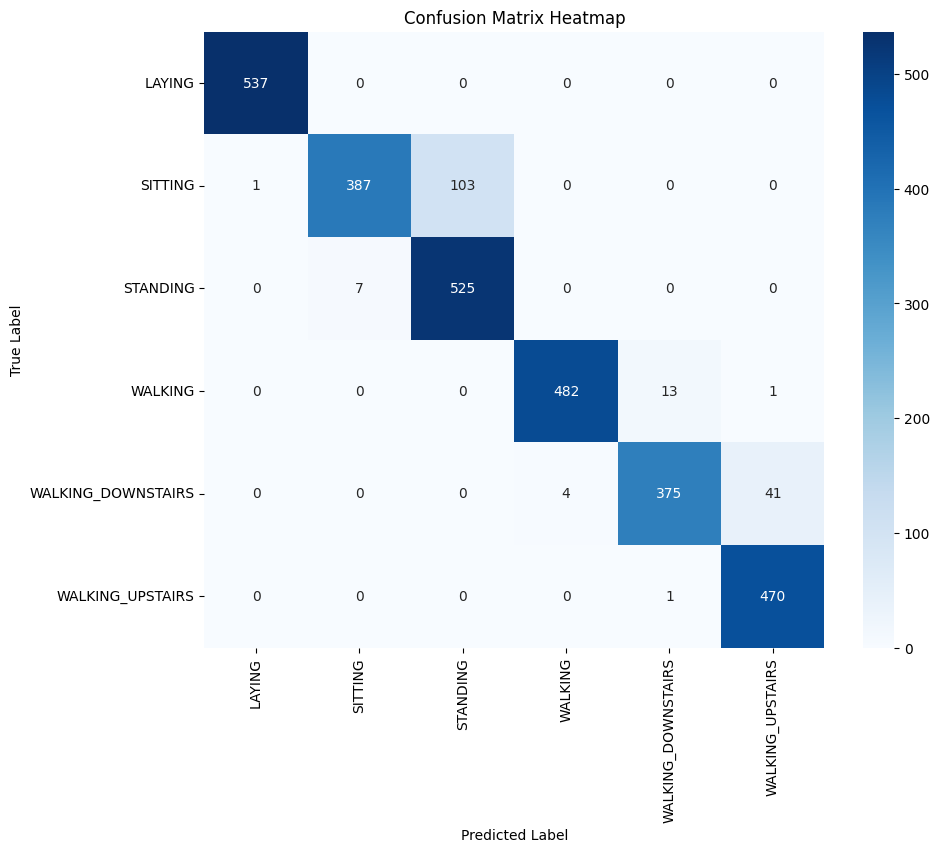

In [99]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

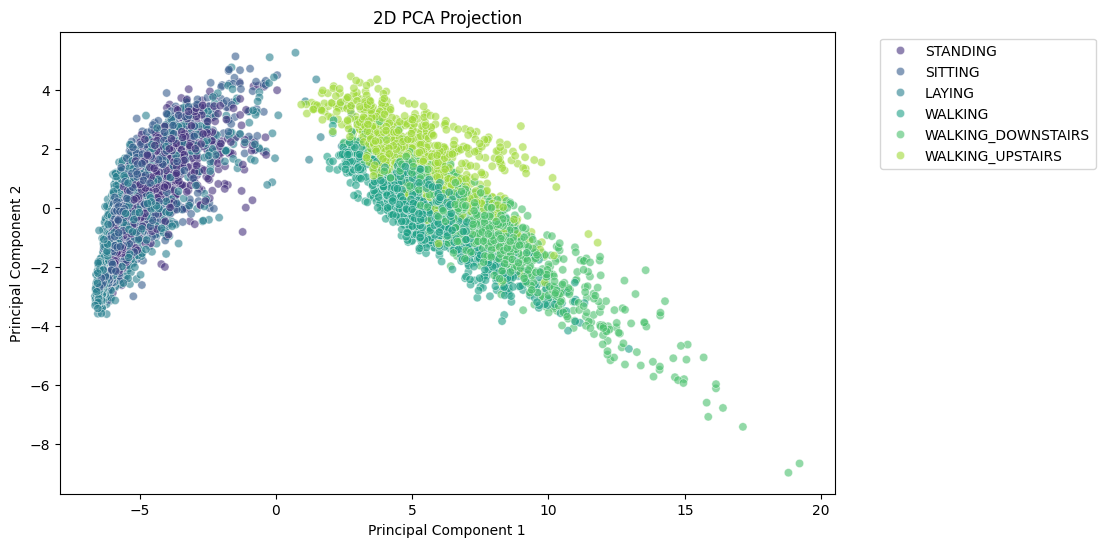

In [100]:
# Apply PCA to reduce the feature space to 2 dimensions
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_features)

# Create a DataFrame with the PCA results and activity labels
pca_df_2d = pd.DataFrame(X_train_pca_2d, columns=['PC1', 'PC2'])
pca_df_2d['Activity'] = y_train_labels

# 2D PCA scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Activity', 
    data=pca_df_2d, 
    palette='viridis', 
    alpha=0.6
)
plt.title("2D PCA Projection")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

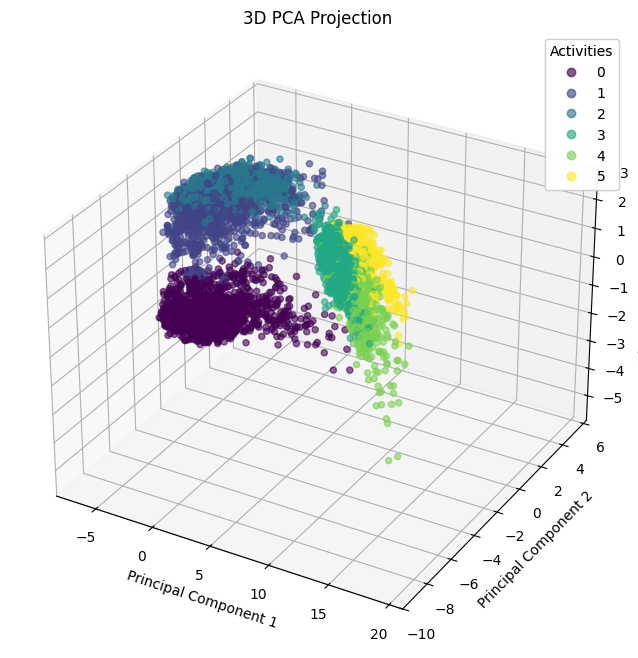

In [101]:
# Apply PCA to reduce the feature space to 3 dimensions
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train_features)

# Create a DataFrame with the PCA results and activity labels
pca_df_3d = pd.DataFrame(X_train_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['Activity'] = y_train_labels

# 3D PCA scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_df_3d['PC1'], 
    pca_df_3d['PC2'], 
    pca_df_3d['PC3'], 
    c=pca_df_3d['Activity'].astype('category').cat.codes, 
    cmap='viridis', 
    alpha=0.6
)
ax.set_title("3D PCA Projection")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
legend1 = ax.legend(*scatter.legend_elements(), title="Activities")
ax.add_artist(legend1)
plt.show()